In [5]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np 
import pandas as pd

In [7]:
dataset_path = "../dataset.csv"
full = False

df = pd.read_csv(
    dataset_path,
    # dtype is specified to prevent a DtypeWarning
    dtype={
        "full_query": str,
        "label": int,
        "statement_type": str,
        "query_template_id": str,
        "attack_payload": str,
        "attack_id": str,
        "attack_technique": str,
        "attack_desc": str,
        "split": str,
        "sqlmap_status" : str,
        "attack_stage" : str,
    },
)


## Generic stats   


In [8]:
def display_counts_recon(df : pd.DataFrame):
    result = df.groupby('attack_id')['attack_stage'].value_counts().unstack(fill_value=0)
    
    if full:
        with pd.option_context('display.max_rows', None, 
                        'display.max_columns', None,
                        'display.width', None,
                        'display.max_colwidth', None):
            display(result)
    else: 
        display(result)

        
_ = display_counts_recon(df)


attack_stage,exploit,recon
attack_id,,
error-0,2,462
error-1,2,225
error-2,2,1388
error-3,2,447
error-4,1,76
error-5,2,1602
error-6,2,477
error-7,2,1525
error-8,1,579


In [9]:
def display_attack_normal_per_set(df : pd.DataFrame):
    df_train_atk = df[(df["label"] == 1) & (df["split"] == "train")]  
    df_train_normal = df[(df["label"] == 0) & (df["split"] == "train")]  

    df_test_atk = df[(df["label"] == 1) & (df["split"] == "test")]  
    df_test_normal = df[(df["label"] == 0) & (df["split"] == "test")]  

    print(f"Number of attacks in train: {df_train_atk.shape[0]}")
    print(f"Number of normal in train: {df_train_normal.shape[0]}")
    print(f"Number of attacks in test: {df_test_atk.shape[0]}")
    print(f"Number of normal in test: {df_test_normal.shape[0]}")

display_attack_normal_per_set(df)

Number of attacks in train: 4354
Number of normal in train: 4567
Number of attacks in test: 2443
Number of normal in test: 26936


In [10]:
def display_ids_per_set(df: pd.DataFrame):
    df_train = df[df["split"] == "train"]
    df_test = df[df["split"] == "test"]

    tids_train = df_train["query_template_id"].unique()
    tids_test = df_test["query_template_id"].unique()
    tids_complement = set(tids_test) - set(tids_train)
    print(f"Template IDS in df train: {len(tids_train)}, {tids_train}")
    print(f"Template IDS in df test:   {len(tids_test)}, {tids_test}")
    print(
        f"Template IDs in test but NOT in train: {len(tids_complement)}, {tids_complement}"
    )

    # Compute which template only have normal queries
    df_n = df.loc[df["label"] == 0,"query_template_id"].unique()
    df_a = df.loc[df["label"] == 1,"query_template_id"].unique()

    print(f"Templates IDs with no attacks: {set(df_n) - set(df_a)}")


display_ids_per_set(df)

Template IDS in df train: 22, ['airport-S10' 'airport-D7' 'airport-S8' 'airport-I5' 'airport-I9'
 'airport-D6' 'airport-S11' 'airport-U3' 'airport-admin14'
 'airport-admin1' 'airport-admin11' 'airport-admin13' 'airport-admin12'
 'airport-admin6' 'airport-admin8' 'airport-admin2' 'airport-admin5'
 'airport-admin4' 'airport-admin9' 'airport-admin7' 'airport-admin10'
 'airport-admin3']
Template IDS in df test:   24, ['airport-I5' 'airport-I4' 'airport-S8' 'airport-S14' 'airport-I9'
 'airport-U3' 'airport-D7' 'airport-S11' 'airport-S10' 'airport-D6'
 'airport-admin14' 'airport-admin3' 'airport-admin13' 'airport-admin11'
 'airport-admin2' 'airport-admin10' 'airport-admin9' 'airport-admin6'
 'airport-admin1' 'airport-admin12' 'airport-admin4' 'airport-admin5'
 'airport-admin7' 'airport-admin8']
Template IDs in test but NOT in train: 2, {'airport-I4', 'airport-S14'}
Templates IDs with no attacks: {'airport-admin6', 'airport-admin3', 'airport-admin11', 'airport-admin10', 'airport-admin2', 'air

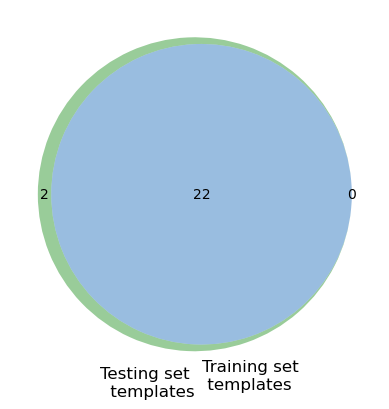

In [11]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

def plot_templates_in_sets(df : pd.DataFrame): 
        
    df_train = df[df["split"] == "train"]
    df_test = df[df["split"] == "test"]
    
    tids_train = df_train["query_template_id"].unique()
    tids_test = df_test["query_template_id"].unique()
    venn2((set(tids_test),set(tids_train)), ("Testing set \n templates","Training set \n templates"),set_colors=("green","blue"))
    plt.show()

plot_templates_in_sets(df=df)

In [12]:
def _stmt_proportion(df: pd.DataFrame):
    return df['statement_type'].value_counts(normalize=True)

def display_ratio_per_stmt(df : pd.DataFrame):
    
    df_a = df[df["label"] == 1]
    df_n = df[df["label"] == 0]
    print(f"Proportion amongst normal: {_stmt_proportion(df=df_n)}")
    print(f"Proportion amongst attacks: {_stmt_proportion(df=df_a)}")
        
    df_train = df[df["split"] == "train"]
    df_test = df[df["split"] == "test"]
    print(f"Proportion amongst train: {_stmt_proportion(df=df_train)}")
    print(f"Proportion amongst test: {_stmt_proportion(df=df_test)}")

    dfntest = df_test[df_test["label"] == 0]

display_ratio_per_stmt(df=df)

Proportion amongst normal: statement_type
select    0.693109
update    0.100784
insert    0.100371
delete    0.095800
admin     0.009936
Name: proportion, dtype: float64
Proportion amongst attacks: statement_type
insert    0.545976
select    0.350154
update    0.070472
delete    0.033397
Name: proportion, dtype: float64
Proportion amongst train: statement_type
select    0.527183
insert    0.291111
update    0.101110
delete    0.074767
admin     0.005829
Name: proportion, dtype: float64
Proportion amongst test: statement_type
select    0.664148
insert    0.145546
update    0.093672
delete    0.087750
admin     0.008884
Name: proportion, dtype: float64


In [16]:
def print_stats_original(df : pd.DataFrame):
    df_og = df[df["template_split"] == "original"]
    df_chall = df[df["template_split"] == "challenging"]

    tids_og = df_og["query_template_id"].unique()
    tids_chall = df_chall["query_template_id"].unique()
    print(f"Template IDS in df original: {len(tids_og)}, {tids_og}")
    print(f"Template IDS in df challenging:   {len(tids_chall)}, {tids_chall}")
    
    print(f"Queries in original set: {len(df_og)}")
    df_a = df_og[df_og["label"] == 1]
    df_n = df_og[df_og["label"] == 0]
    print(f"Number of attacks in original: {df_a.shape[0]}")
    print(f"Number of normal in original: {df_n.shape[0]}")

    print(f"Queries in challenging set: {len(df_chall)}")
    df_a = df_chall[df_chall["label"] == 1]
    df_n = df_chall[df_chall["label"] == 0]
    print(f"Number of attacks in challenging: {df_a.shape[0]}")
    print(f"Number of normal in challenging: {df_n.shape[0]}")
print_stats_original(df=df)

Template IDS in df original: 22, ['airport-I5' 'airport-S8' 'airport-I9' 'airport-U3' 'airport-D7'
 'airport-S11' 'airport-S10' 'airport-D6' 'airport-admin14'
 'airport-admin3' 'airport-admin13' 'airport-admin11' 'airport-admin2'
 'airport-admin10' 'airport-admin9' 'airport-admin6' 'airport-admin1'
 'airport-admin12' 'airport-admin8' 'airport-admin5' 'airport-admin4'
 'airport-admin7']
Template IDS in df challenging:   2, ['airport-I4' 'airport-S14']
Queries in original set: 32087
Number of attacks in original: 6140
Number of normal in original: 25947
Queries in challenging set: 6213
Number of attacks in challenging: 657
Number of normal in challenging: 5556
